In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas
from helper_scripts import random_rm_trace_generator
import importlib
from matplotlib import pyplot as plt
from modules import umap_classifier

/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-14 12:20:30.450599: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 12:20:30.466564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755166830.482469 4008787 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755166830.487195 4008787 cuda_blas

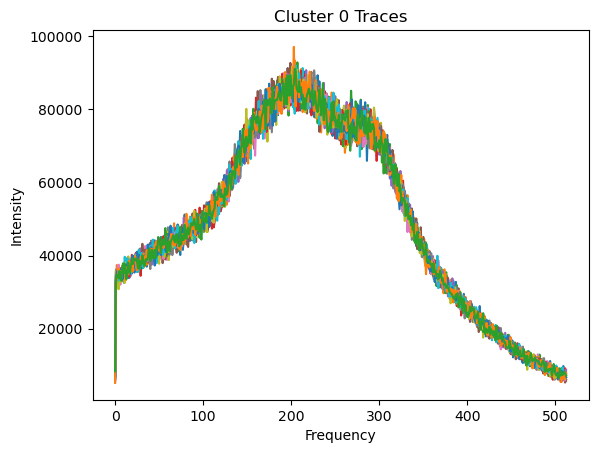

In [2]:
cluster_idx = 0
time_traces, spectra, phase, clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(100, n_clusters=4, outlier_fraction=0.05)
for i in range(100):
    if clusters[i] == cluster_idx:
        plt.plot(spectra[i], label=f'Trace {i+1}')
        plt.xlabel('Frequency')
        plt.ylabel('Intensity')
plt.title(f'Cluster {cluster_idx} Traces')
plt.show()

In [3]:
importlib.reload(umap_classifier)
importlib.reload(random_rm_trace_generator)

<module 'helper_scripts.random_rm_trace_generator' from '/cr/work/kastner/private/umap/rm_classifier/tutorials/notebooks/helper_scripts/random_rm_trace_generator.py'>

In [4]:
u_clas = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", data_preparation={'target_data_type': "time"})

In [5]:
prepared_data=u_clas.prepare_data(time_traces, input_data_type="time",  data_preparation={'target_data_type': "fft_time"}, 
                 log_filter=False,avg_pooling=4,verbose=False,
                 normalization=False,
                 suppress_dc=True)

In [6]:
embeddings=u_clas.embed(prepared_data, save_model="umap_model.pkl")

Embedding data with parameters: n_neighbors=40, min_dist=0.0, n_components=2, metric=braycurtis


/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving UMAP model to umap_model.pkl


/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


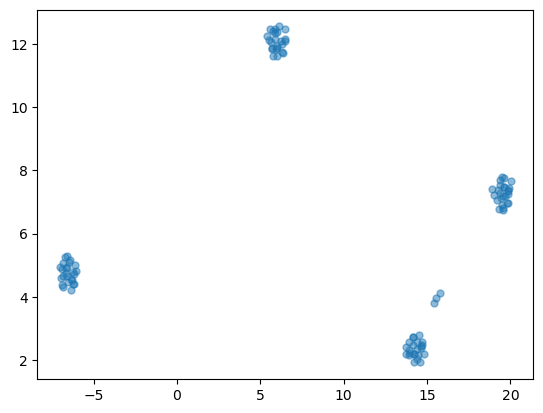

In [7]:
plt.plot(embeddings[:, 0], embeddings[:, 1], 'o', markersize=5, alpha=0.5)

In [8]:
clusters=u_clas.classify(embeddings, db_min_samples=10, db_eps=0.5)
u_clas.cluster_indices

Overriding db_min_samples with value 10 from kwargs.
Overriding db_eps with value 0.5 from kwargs.


array([0, 1, 2, 3])

In [9]:
u_clas.save_cluster_trace(prepared_data, clusters, trace_statistic="mean")

Saved 4 cluster traces with mean statistic.


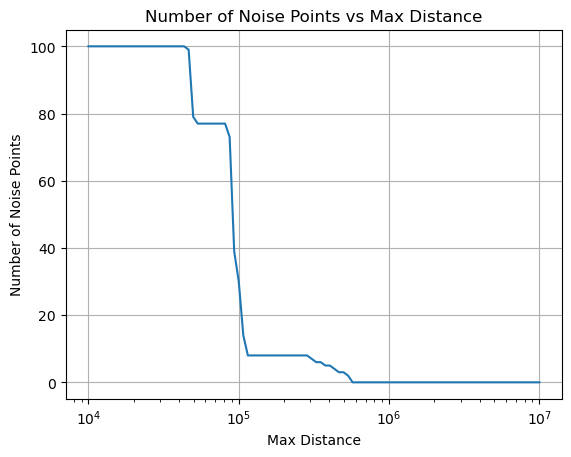

In [10]:
n_noise=[]
for max_distance in np.logspace(3,7,100):
    predictions, min_distances=u_clas.minimum_distance_prediction(prepared_data, max_distance=max_distance)
    n_noise.append(np.sum(predictions == -1))

plt.plot(np.logspace(4,7,100), n_noise)
plt.xscale('log')
plt.xlabel('Max Distance')
plt.ylabel('Number of Noise Points')
plt.title('Number of Noise Points vs Max Distance')
plt.grid(True)
plt.show()

In [11]:
u_clas.save_cluster_trace(prepared_data,clusters,trace_statistic="mean")
u_clas.save_cluster_trace(prepared_data,clusters,trace_statistic="std")
predictions, mls = u_clas.ml_uncorrelated_normal_prediction(prepared_data)

Saved 4 cluster traces with mean statistic.
Saved 4 cluster traces with std statistic.


In [12]:
predictions, mls = u_clas.ml_uncorrelated_normal_prediction(prepared_data, min_logl=-2000)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 1, 3, 2, 1, 3])

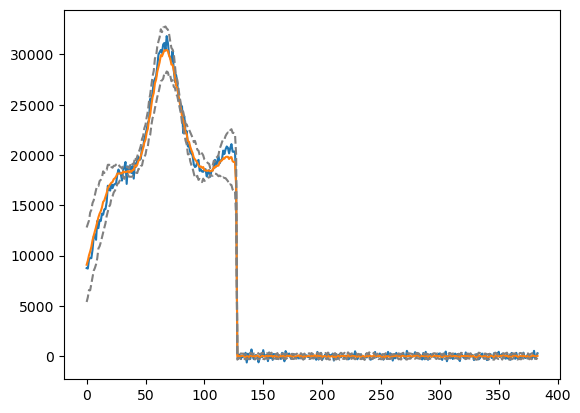

In [13]:
idx=59
cluster_idx=clusters[idx]
plt.plot(prepared_data[idx])
plt.plot(u_clas.cluster_mean_traces[cluster_idx])
plt.plot(u_clas.cluster_mean_traces[cluster_idx] + u_clas.cluster_std_traces[cluster_idx], linestyle='--', color='gray')
plt.plot(u_clas.cluster_mean_traces[cluster_idx] - u_clas.cluster_std_traces[cluster_idx], linestyle='--', color='gray')

In [14]:
u_clas.save_cluster_cholesky_factors(prepared_data,clusters)
predictions, mls = u_clas.ml_correlated_normal_prediction(prepared_data)

Saved 4 cluster Cholesky factors.


In [15]:
predictions, embeddings = u_clas.umap_transform_prediction(prepared_data, db_eps=0)

Transforming data with UMAP model and predicting clusters with DBSCAN (eps=0)
Processing batch 0 to 20000
Creating DBSCAN model


/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
u_clas.save_cluster_trace(prepared_data, clusters, trace_statistic="quantile", q=0.1)
u_clas.save_cluster_trace(prepared_data, clusters, trace_statistic="quantile", q=0.9)
u_clas.save_cluster_trace(prepared_data, clusters, trace_statistic="median")

Saved 4 cluster traces with quantile statistic.
Saved 4 cluster traces with quantile statistic.
Saved 4 cluster traces with median statistic.


In [17]:
u_clas.cluster_mean_traces.shape

(4, 384)

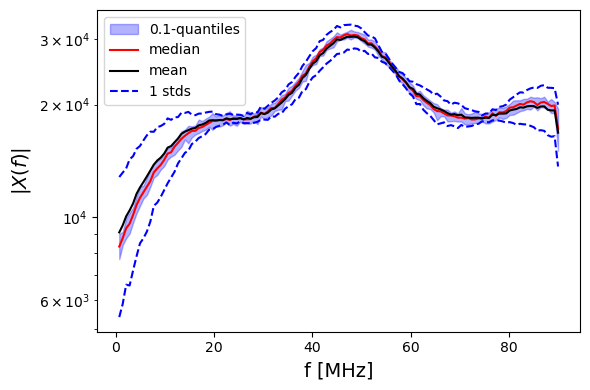

In [23]:
u_clas.plot_spectra(2, q=0.1, sigma=1, plot_types=["fft"])